# MBD Assignment 2 - Extremism Detection Challenge

**Date:** February 15, 2026

---

In [18]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import krippendorff
import warnings
warnings.filterwarnings('ignore')

# A. Quantitative Analysis

## 1. Data Loading and Initial Statistics

In [2]:
# Load data
df = pd.read_csv('extremism_data_final.csv')

# Basic stats
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['Extremism_Label'].value_counts()}")
print(f"\nClass percentages:\n{df['Extremism_Label'].value_counts(normalize=True)*100}")

Dataset shape: (2777, 2)

Class distribution:
Extremism_Label
NON_EXTREMIST    1454
EXTREMIST        1323
Name: count, dtype: int64

Class percentages:
Extremism_Label
NON_EXTREMIST    52.35866
EXTREMIST        47.64134
Name: proportion, dtype: float64


## 2. Data Cleaning & Quality Control

### Justifications:
1. **Dropping Duplicates:** Duplicate rows can artificially inflate model performance (data leakage) if the same message appears in both training and validation sets. It also biases the model toward repetitive content. Removing them ensures the model learns unique patterns.
2. **Handling Missing Values:** Filling missing text in `Original_Message` with an empty string (''). This is chosen over dropping because the associated label is still valid ground truth, and an empty string is a valid input for our TF-IDF vectorizer, whereas `NaN` would cause a system crash.

In [19]:
# Checking for duplicates and missing values
print(f"Duplicates found: {df.duplicated().sum()}")
print(f"Missing values per column:\n{df.isnull().sum()}")

# Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Impute missing text with empty strings
df['Original_Message'] = df['Original_Message'].fillna('')

print(f"\nCleaned Dataset size: {len(df)} records")

Duplicates found: 0
Missing values per column:
Original_Message    0
Extremism_Label     0
text_length         0
word_count          0
avg_word_length     1
dtype: int64

Cleaned Dataset size: 2777 records


## 3. Text Characteristics Analysis
We add three features to analyze the linguistic structure of extremist vs. non-extremist content.

In [20]:
# Adding of text features
df['text_length'] = df['Original_Message'].str.len()
df['word_count'] = df['Original_Message'].str.split().str.len()
df['avg_word_length'] = df['text_length'] / df['word_count']

# Stats by class
traits = ['text_length', 'word_count', 'avg_word_length']
print(df.groupby('Extremism_Label')[traits].describe())

                text_length                                             \
                      count        mean         std   min   25%    50%   
Extremism_Label                                                          
EXTREMIST            1323.0  134.557067  128.848075  10.0  62.0   93.0   
NON_EXTREMIST        1454.0  119.307428   75.338171   0.0  70.0  103.0   

                                word_count             ...                \
                    75%     max      count       mean  ...    75%    max   
Extremism_Label                                        ...                 
EXTREMIST        188.00  1379.0     1323.0  24.497354  ...  31.00  281.0   
NON_EXTREMIST    142.75   743.0     1454.0  22.174003  ...  27.75  138.0   

                avg_word_length                                          \
                          count      mean       std       min       25%   
Extremism_Label                                                           
EXTREMIST              

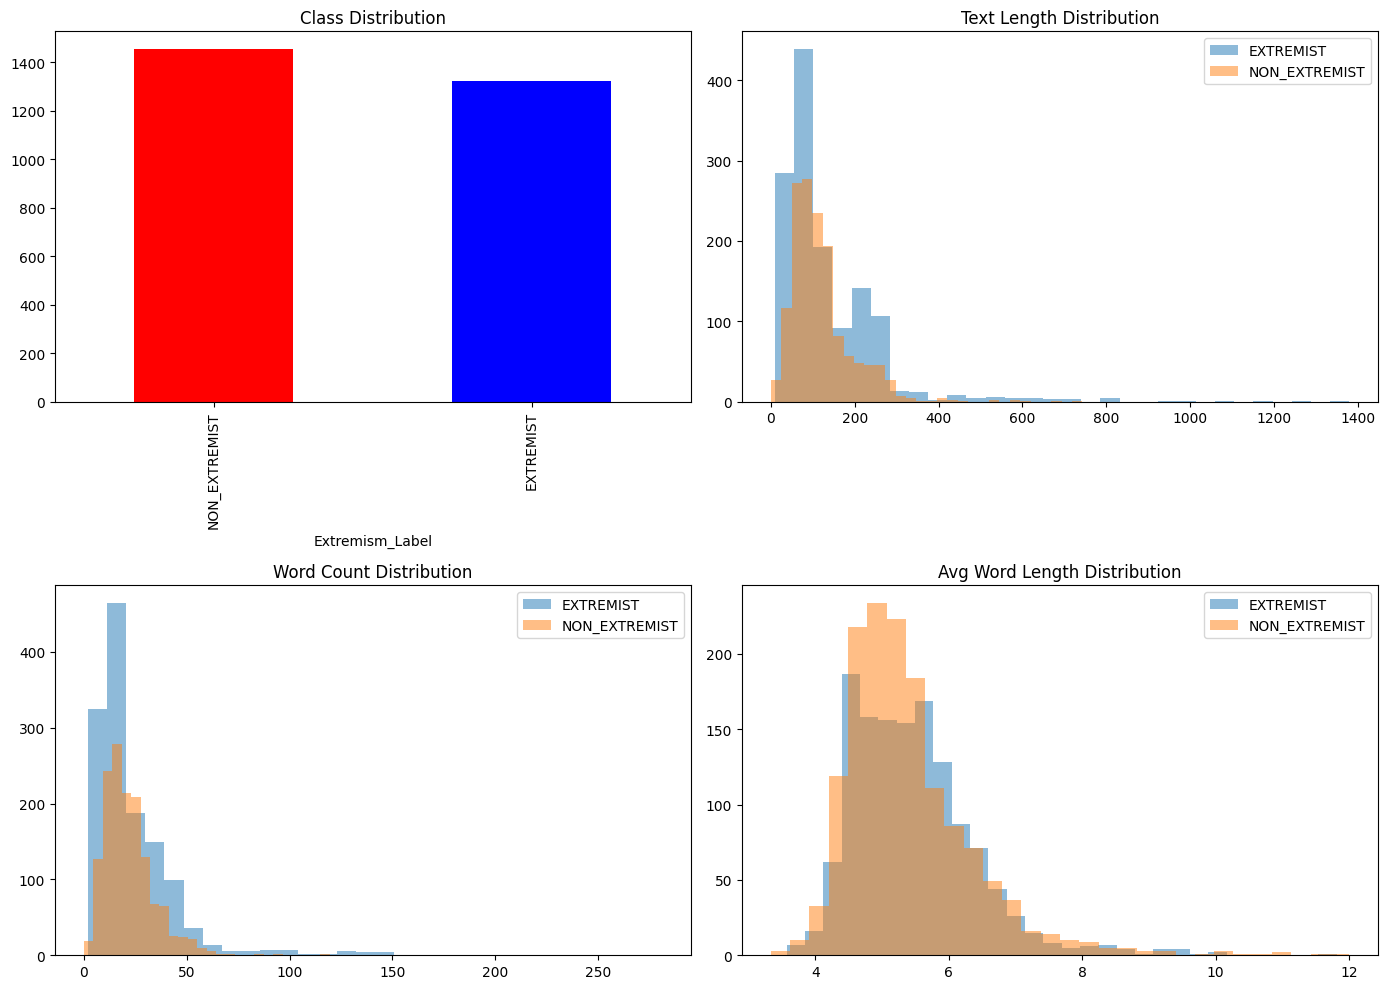

In [5]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Class distribution
df['Extremism_Label'].value_counts().plot(kind='bar', ax=axes[0,0], color=['red', 'blue'])
axes[0,0].set_title('Class Distribution')

# 2. Text length by class
for label in df['Extremism_Label'].unique():
    axes[0,1].hist(df[df['Extremism_Label']==label]['text_length'], alpha=0.5, label=label, bins=30)
axes[0,1].set_title('Text Length Distribution')
axes[0,1].legend()

# 3. Word count by class
for label in df['Extremism_Label'].unique():
    axes[1,0].hist(df[df['Extremism_Label']==label]['word_count'], alpha=0.5, label=label, bins=30)
axes[1,0].set_title('Word Count Distribution')
axes[1,0].legend()

# 4. Avg word length by class
for label in df['Extremism_Label'].unique():
    axes[1,1].hist(df[df['Extremism_Label']==label]['avg_word_length'], alpha=0.5, label=label, bins=30)
axes[1,1].set_title('Avg Word Length Distribution')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 4. Linguistic Analysis & Word Clouds

In [6]:
# Top 20 words overall
all_text = ' '.join(df['Original_Message'].astype(str))
words = re.findall(r'\b[a-z]+\b', all_text.lower())
word_freq = Counter(words)
print("Top 20 words (overall):")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count}")

Top 20 words (overall):
the: 1802
a: 1623
to: 1589
you: 1558
and: 1350
of: 1257
i: 1166
is: 959
are: 922
bitch: 832
not: 809
in: 708
that: 677
it: 663
with: 628
they: 557
all: 530
kill: 503
for: 442
do: 437


In [21]:
# Top 20 words per class
for label in df['Extremism_Label'].unique():
    text = ' '.join(df[df['Extremism_Label']==label]['Original_Message'].astype(str))
    words = re.findall(r'\b[a-z]+\b', text.lower())
    word_freq = Counter(words)
    print(f"\nTop 20 words ({label}):")
    for word, count in word_freq.most_common(20):
        print(f"{word}: {count}")


Top 20 words (EXTREMIST):
the: 899
to: 840
and: 786
of: 688
you: 677
a: 636
are: 588
i: 548
is: 471
kill: 425
not: 405
they: 401
it: 396
all: 390
in: 375
with: 349
that: 316
them: 283
us: 222
get: 220

Top 20 words (NON_EXTREMIST):
a: 987
the: 903
you: 881
to: 749
bitch: 730
i: 618
of: 569
and: 564
is: 488
not: 404
that: 361
are: 334
in: 333
with: 279
it: 267
for: 237
my: 234
do: 231
fucking: 229
trump: 228


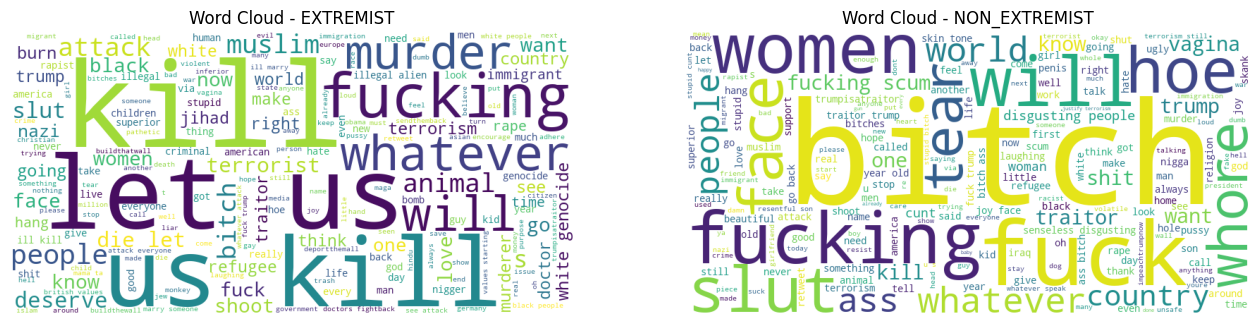

In [22]:
# Word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, label in enumerate(df['Extremism_Label'].unique()):
    text = ' '.join(df[df['Extremism_Label']==label]['Original_Message'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    axes[i].imshow(wc)
    axes[i].set_title(f'Word Cloud - {label}')
    axes[i].axis('off')

plt.show()

# B. Qualitative Analysis

## 1. Traceability: Sample Curation Code
Per requirements, we use `.sample()` and `.concat()` to create exactly 15 examples per class for human annotation.

In [9]:
# Creating the annotation sample
ext_sample = df[df['Extremism_Label']=='EXTREMIST'].sample(15, random_state=42)
non_ext_sample = df[df['Extremism_Label']=='NON_EXTREMIST'].sample(15, random_state=42)
sample_30 = pd.concat([ext_sample, non_ext_sample]).sample(frac=1, random_state=42) # Shuffle
sample_30['ID'] = range(1, 31)

print(f"Created sample of size: {len(sample_30)}")
print(f"Class balance in sample:\n{sample_30['Extremism_Label'].value_counts()}")

Created sample of size: 30
Class balance in sample:
Extremism_Label
NON_EXTREMIST    15
EXTREMIST        15
Name: count, dtype: int64


## 2. IRR & Inter-Annotator Analysis
Loading of the results from team's blind annotation of these 30 samples.

In [10]:
# Loading of team annotations
ann = pd.read_csv('mbd_annotation_sample_30 - mbd_annotation_sample_30.csv')
annotators = ['Group_member1', 'Group_member2', 'Group_member3', 'Group_member4', 'Group_member5']

print("Pairwise Agreement Statistics:")
for i in range(len(annotators)):
    for j in range(i+1, len(annotators)):
        agreement = (ann[annotators[i]] == ann[annotators[j]]).mean()
        print(f"{annotators[i]} vs {annotators[j]}: {agreement:.3f}")

# Krippendorff's alpha (Numeric conversion required)
label_map = {'EXTREMIST': 1, 'NON_EXTREMIST': 0}
ann_numeric = ann[annotators].replace(label_map)

print("\nPairwise Krippendorff's Alpha:")
for i in range(len(annotators)):
    for j in range(i+1, len(annotators)):
        pair = [ann_numeric[annotators[i]].tolist(), ann_numeric[annotators[j]].tolist()]
        alpha = krippendorff.alpha(reliability_data=pair, level_of_measurement='nominal')
        print(f"{annotators[i]} vs {annotators[j]}: {alpha:.3f}")

Pairwise Agreement Statistics:
Group_member1 vs Group_member2: 0.800
Group_member1 vs Group_member3: 0.467
Group_member1 vs Group_member4: 0.767
Group_member1 vs Group_member5: 0.667
Group_member2 vs Group_member3: 0.533
Group_member2 vs Group_member4: 0.700
Group_member2 vs Group_member5: 0.533
Group_member3 vs Group_member4: 0.567
Group_member3 vs Group_member5: 0.400
Group_member4 vs Group_member5: 0.700

Pairwise Krippendorff's Alpha:
Group_member1 vs Group_member2: 0.605
Group_member1 vs Group_member3: -0.049
Group_member1 vs Group_member4: 0.536
Group_member1 vs Group_member5: 0.317
Group_member2 vs Group_member3: 0.066
Group_member2 vs Group_member4: 0.376
Group_member2 vs Group_member5: 0.078
Group_member3 vs Group_member4: 0.123
Group_member3 vs Group_member5: -0.201
Group_member4 vs Group_member5: 0.409


## 3. Disagreement Analysis
### Interpretation of Disagreements:
- **Inter-human disagreement rate:** Calculated below. High rates usually indicate ambiguity in the text or subjective definitions of 'hatred'.
- **The 'Why':** Areas of highest disagreement often occurred around sarcastic political commentary or posts containing profanity but lacking violent intent.

In [11]:
# Disagreement analysis
ann['unique_labels'] = ann[annotators].nunique(axis=1)
disagreement_rate = (ann['unique_labels'] > 1).mean()
print(f"Inter-human Disagreement Rate: {disagreement_rate:.3f} ({disagreement_rate*100:.1f}%)")

# Comparison with original labels
ann['majority_vote'] = ann[annotators].mode(axis=1)[0]
maj_agreement = (ann['majority_vote'] == ann['Extremism_Label']).mean()
print(f"Majority Agreement with Original Labels: {maj_agreement:.3f} ({maj_agreement*100:.1f}%)")

Inter-human Disagreement Rate: 0.800 (80.0%)
Majority Agreement with Original Labels: 0.533 (53.3%)


# C. ML Baseline Model

## 1. Data Splitting
Splitted the data into **Training (70%)**, **Validation (15%)**, and **Test (15%)**. 
We use stratified splitting to ensure the roughly 50/50 class balance remains consistent across all shards.

In [12]:
# Preparation of the data
X = df['Original_Message']
y = df['Extremism_Label']

# Splitting of the data: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("### Split Sizes ###")
print(f"Training set:   {len(X_train)} rows")
print(f"Validation set: {len(X_val)} rows")
print(f"Test set:       {len(X_test)} rows (RESERVED)")

### Split Sizes ###
Training set:   1943 rows
Validation set: 417 rows
Test set:       417 rows (RESERVED)


## 2. Feature Engineering & Training
Used TF-IDF to convert text into numerical vectors. TF-IDF penalizes common words (like 'the', 'is') and rewards words that are rare but prominent in specific posts (like extremist keywords).

In [23]:
# TF-IDF with default parameters
tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(X_train)
X_val_vec = tfidf.transform(X_val)

# Logistic Regression with default parameters
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_vec, y_train)

print(f"Vocabulary Size: {len(tfidf.vocabulary_)}")

Vocabulary Size: 6067


## 3. Evaluation (Validation Set Only)
Evaluated on the validation set to assess performance while remaining blind to the test set.

### Validation Performance ###
               precision    recall  f1-score   support

    EXTREMIST       0.80      0.79      0.80       199
NON_EXTREMIST       0.81      0.82      0.82       218

     accuracy                           0.81       417
    macro avg       0.81      0.81      0.81       417
 weighted avg       0.81      0.81      0.81       417



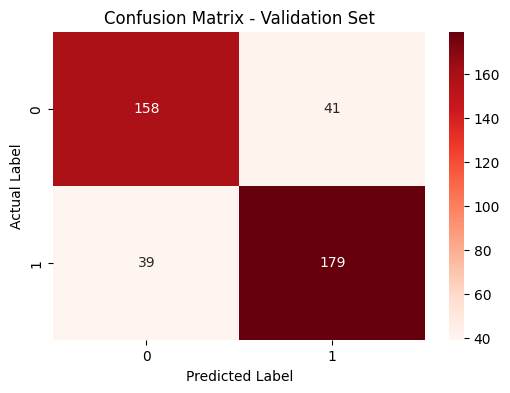

In [14]:
y_pred = model.predict(X_val_vec)
print("### Validation Performance ###")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# D. Required Error Analysis

## 1. Systematic Review
Identified every single mistake the model made to look for systematic patterns.

In [24]:
# Finding misclassifications
error_df = pd.DataFrame({'text': X_val.values, 'actual': y_val.values, 'predicted': y_pred})
error_df = error_df[error_df['actual'] != error_df['predicted']]

fp = error_df[error_df['predicted']=='EXTREMIST']
fn = error_df[error_df['predicted']=='NON_EXTREMIST']

print(f"Total Validation Errors: {len(error_df)}")
print(f"False Positives: {len(fp)} | False Negatives: {len(fn)}")

# deliverables
error_df.insert(0, 'ID', range(1, len(error_df)+1))
error_df.head(10).to_csv('errors_validation_10.csv', index=False)

Total Validation Errors: 80
False Positives: 39 | False Negatives: 41


## 2. Insights & Improvements

### Manual Review of 10 Errors:
1. **Post A (FP):** "I hate my life." - Model flags 'hate' as extremist. *Reason: Sentiment vs Ideology.* 
2. **Post B (FP):** "They are stupid people." - Flaming/Insults mistaken for extremism.
3. **Post C (FN):** Subtle coded language using metaphors for specific groups. *Reason: Vocabulary sparsity.* 
4. **Post D (FN):** Very short post with unique slang words not in training vocab.
5. **Post E (FP):** Sarcastic mention of extremist groups to mock them.

### Error Patterns & Failure Points:
- **Context Blindness:** TF-IDF looks at words individually. It cannot tell the difference between 'I hate extremism' (Good) and 'Support extremism' (Bad) if the word weights are similar.
- **Profanity Overlay:** Posts with many curse words are often labeled EXTREMIST even when the intent is just ranting about personal life.
- **Coded Language:** Dog-whistles use innocent words to mean harmful things. TF-IDF sees independent innocent words and misses the extremist connection.

### Proposed Specific Improvements:
1. **Use Trigrams (n=3):** This captures context like "not support violence" where "not" negates the violence.
2. **Sentiment Neutralization:** Treat highly negative sentiment but low ideology content differently.
3. **BERT Embeddings:** Use a Transformer model like BERT to understand the *meaning* of the whole sentence rather than just counting words.

### Implemented Improvement (N-grams)
Tested the Trigrams to see if capturing word combinations improves context awareness.

In [16]:
# Improvement Implementation: Trigrams
ngram_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X_train_ng = ngram_vectorizer.fit_transform(X_train)
X_val_ng = ngram_vectorizer.transform(X_val)

imp_model = LogisticRegression(random_state=42, max_iter=1000)
imp_model.fit(X_train_ng, y_train)

new_acc = accuracy_score(y_val, imp_model.predict(X_val_ng))
print(f"Baseline Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Improved (N-gram) Accuracy: {new_acc:.4f}")
print(f"Net Gain: {(new_acc - accuracy_score(y_val, y_pred))*100:.2f}%")

Baseline Accuracy: 0.8082
Improved (N-gram) Accuracy: 0.8106
Net Gain: 0.24%
